##Nuclei detection with Mask RCNN

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

D:\Anaconda3\envs\kaggle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


... done downloading pretrained model!


##Configuration

In [2]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000

## Dataset

Create a nuclei dataset



In [3]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [8]:
category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
white = cate.loc[cate['foreground'] == 'white','filename'].tolist()
purple = cate.loc[cate['foreground'] == 'purple','filename'].tolist()
black = cate.loc[cate['foreground'] == 'black','filename'].tolist()
print("number of black image: %d" %len(black))
print("number of purple image: %d" %len(purple))
print("number of white image: %d" %len(white))

number of black image: 16
number of purple image: 120
number of white image: 599


In [9]:
train_index = [n for i, n in enumerate(train_ids) if n+".png" in white[:int(len(white)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) if n+".png" in white[int(len(white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) if n+".png" in purple[:int(len(purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) if n+".png" in purple[int(len(purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) if n+".png" in black[:int(len(black)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) if n+".png" in black[int(len(black)*0.8):]]

print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 534
length of validation set: 136
False


In [10]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

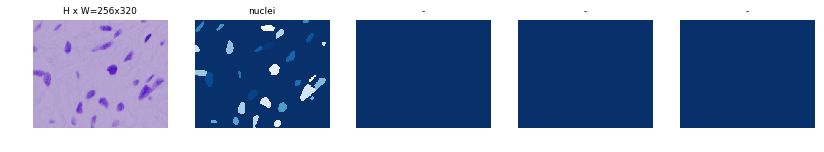

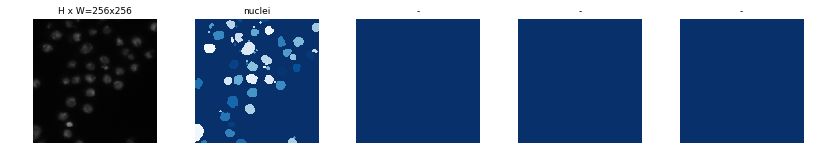

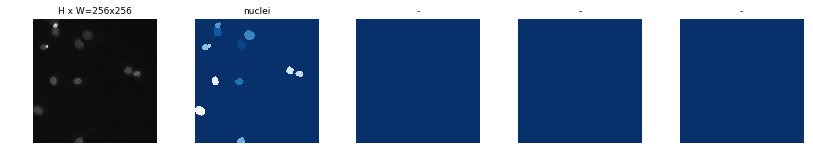

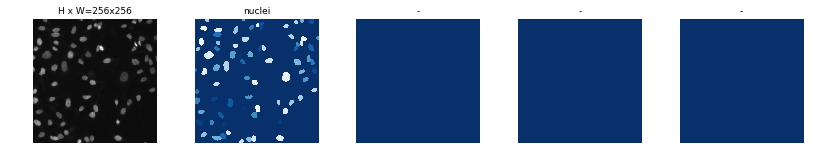

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [80]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [64]:
# Which weights to start with? Used coco weights? 
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [65]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180322T0013/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 55:24 - loss: 7.6609 - rpn_class_loss: 0.9995 - rpn_bbox_loss: 2.2630 - mrcnn_class_loss: 2.4073 - mrcnn_bbox_loss: 1.2392 - mrcnn_mask_loss: 0.7519

ERROR:root:Error processing image {'id': 97, 'source': 'nuclei', 'path': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/images/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288.png', 'maskpath': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

  2/100 [..............................] - ETA: 47:24 - loss: 7.8528 - rpn_class_loss: 1.1498 - rpn_bbox_loss: 2.5657 - mrcnn_class_loss: 2.0253 - mrcnn_bbox_loss: 1.3776 - mrcnn_mask_loss: 0.7343

  3/100 [..............................] - ETA: 43:38 - loss: 7.8602 - rpn_class_loss: 1.4320 - rpn_bbox_loss: 2.7786 - mrcnn_class_loss: 1.5227 - mrcnn_bbox_loss: 1.4105 - mrcnn_mask_loss: 0.7164

  4/100 [>.............................] - ETA: 41:21 - loss: 6.9585 - rpn_class_loss: 1.1181 - rpn_bbox_loss: 2.5240 - mrcnn_class_loss: 1.1755 - mrcnn_bbox_loss: 1.4308 - mrcnn_mask_loss: 0.7101

  5/100 [>.............................] - ETA: 39:00 - loss: 6.4731 - rpn_class_loss: 1.0881 - rpn_bbox_loss: 2.3526 - mrcnn_class_loss: 1.0065 - mrcnn_bbox_loss: 1.3230 - mrcnn_mask_loss: 0.7029

  6/100 [>.............................] - ETA: 37:20 - loss: 5.8821 - rpn_class_loss: 0.9716 - rpn_bbox_loss: 2.1595 - mrcnn_class_loss: 0.8440 - mrcnn_bbox_loss: 1.2069 - mrcnn_mask_loss: 0.7000

  7/100 [=>............................] - ETA: 35:30 - loss: 5.7538 - rpn_class_loss: 0.9190 - rpn_bbox_loss: 2.1761 - mrcnn_class_loss: 0.7712 - mrcnn_bbox_loss: 1.1753 - mrcnn_mask_loss: 0.7121

  8/100 [=>............................] - ETA: 33:58 - loss: 5.8200 - rpn_class_loss: 1.1781 - rpn_bbox_loss: 2.0926 - mrcnn_class_loss: 0.6945 - mrcnn_bbox_loss: 1.1496 - mrcnn_mask_loss: 0.7053

  9/100 [=>............................] - ETA: 32:48 - loss: 5.5413 - rpn_class_loss: 1.0968 - rpn_bbox_loss: 2.0106 - mrcnn_class_loss: 0.6321 - mrcnn_bbox_loss: 1.1109 - mrcnn_mask_loss: 0.6910

 10/100 [==>...........................] - ETA: 31:40 - loss: 5.2852 - rpn_class_loss: 0.9911 - rpn_bbox_loss: 1.9326 - mrcnn_class_loss: 0.5864 - mrcnn_bbox_loss: 1.0883 - mrcnn_mask_loss: 0.6868

 11/100 [==>...........................] - ETA: 30:43 - loss: 5.0380 - rpn_class_loss: 0.9317 - rpn_bbox_loss: 1.8303 - mrcnn_class_loss: 0.5560 - mrcnn_bbox_loss: 1.0425 - mrcnn_mask_loss: 0.6775

 12/100 [==>...........................] - ETA: 29:54 - loss: 4.9733 - rpn_class_loss: 0.9225 - rpn_bbox_loss: 1.7862 - mrcnn_class_loss: 0.5725 - mrcnn_bbox_loss: 1.0231 - mrcnn_mask_loss: 0.6690

 13/100 [==>...........................] - ETA: 29:11 - loss: 4.8763 - rpn_class_loss: 0.8686 - rpn_bbox_loss: 1.7959 - mrcnn_class_loss: 0.5501 - mrcnn_bbox_loss: 1.0069 - mrcnn_mask_loss: 0.6548

 14/100 [===>..........................] - ETA: 28:36 - loss: 4.7863 - rpn_class_loss: 0.8440 - rpn_bbox_loss: 1.7524 - mrcnn_class_loss: 0.5534 - mrcnn_bbox_loss: 0.9897 - mrcnn_mask_loss: 0.6468

 15/100 [===>..........................] - ETA: 28:02 - loss: 4.6551 - rpn_class_loss: 0.8077 - rpn_bbox_loss: 1.7027 - mrcnn_class_loss: 0.5297 - mrcnn_bbox_loss: 0.9769 - mrcnn_mask_loss: 0.6380

 16/100 [===>..........................] - ETA: 27:24 - loss: 4.7119 - rpn_class_loss: 0.8636 - rpn_bbox_loss: 1.7026 - mrcnn_class_loss: 0.5309 - mrcnn_bbox_loss: 0.9798 - mrcnn_mask_loss: 0.6350

 17/100 [====>.........................] - ETA: 26:49 - loss: 4.6562 - rpn_class_loss: 0.8631 - rpn_bbox_loss: 1.6601 - mrcnn_class_loss: 0.5365 - mrcnn_bbox_loss: 0.9654 - mrcnn_mask_loss: 0.6312

 18/100 [====>.........................] - ETA: 26:17 - loss: 4.5519 - rpn_class_loss: 0.8409 - rpn_bbox_loss: 1.6292 - mrcnn_class_loss: 0.5139 - mrcnn_bbox_loss: 0.9395 - mrcnn_mask_loss: 0.6283

 19/100 [====>.........................] - ETA: 25:47 - loss: 4.6090 - rpn_class_loss: 0.8515 - rpn_bbox_loss: 1.6939 - mrcnn_class_loss: 0.4919 - mrcnn_bbox_loss: 0.9369 - mrcnn_mask_loss: 0.6349

 20/100 [=====>........................] - ETA: 25:18 - loss: 4.5964 - rpn_class_loss: 0.8778 - rpn_bbox_loss: 1.6666 - mrcnn_class_loss: 0.4931 - mrcnn_bbox_loss: 0.9239 - mrcnn_mask_loss: 0.6349

 21/100 [=====>........................] - ETA: 24:51 - loss: 4.5027 - rpn_class_loss: 0.8585 - rpn_bbox_loss: 1.6293 - mrcnn_class_loss: 0.4815 - mrcnn_bbox_loss: 0.9039 - mrcnn_mask_loss: 0.6294

 22/100 [=====>........................] - ETA: 24:25 - loss: 4.4231 - rpn_class_loss: 0.8363 - rpn_bbox_loss: 1.5938 - mrcnn_class_loss: 0.4794 - mrcnn_bbox_loss: 0.8879 - mrcnn_mask_loss: 0.6257

 23/100 [=====>........................] - ETA: 23:59 - loss: 4.3554 - rpn_class_loss: 0.8266 - rpn_bbox_loss: 1.5805 - mrcnn_class_loss: 0.4637 - mrcnn_bbox_loss: 0.8678 - mrcnn_mask_loss: 0.6167

 24/100 [======>.......................] - ETA: 23:35 - loss: 4.2824 - rpn_class_loss: 0.8077 - rpn_bbox_loss: 1.5484 - mrcnn_class_loss: 0.4529 - mrcnn_bbox_loss: 0.8587 - mrcnn_mask_loss: 0.6145

 25/100 [======>.......................] - ETA: 23:12 - loss: 4.2774 - rpn_class_loss: 0.8145 - rpn_bbox_loss: 1.5367 - mrcnn_class_loss: 0.4565 - mrcnn_bbox_loss: 0.8544 - mrcnn_mask_loss: 0.6153

 26/100 [======>.......................] - ETA: 22:48 - loss: 4.2165 - rpn_class_loss: 0.7990 - rpn_bbox_loss: 1.5228 - mrcnn_class_loss: 0.4466 - mrcnn_bbox_loss: 0.8397 - mrcnn_mask_loss: 0.6083

 27/100 [=======>......................] - ETA: 22:24 - loss: 4.1628 - rpn_class_loss: 0.7847 - rpn_bbox_loss: 1.4974 - mrcnn_class_loss: 0.4391 - mrcnn_bbox_loss: 0.8389 - mrcnn_mask_loss: 0.6027

 28/100 [=======>......................] - ETA: 22:04 - loss: 4.0964 - rpn_class_loss: 0.7693 - rpn_bbox_loss: 1.4725 - mrcnn_class_loss: 0.4249 - mrcnn_bbox_loss: 0.8315 - mrcnn_mask_loss: 0.5982

 29/100 [=======>......................] - ETA: 21:42 - loss: 4.0274 - rpn_class_loss: 0.7498 - rpn_bbox_loss: 1.4464 - mrcnn_class_loss: 0.4151 - mrcnn_bbox_loss: 0.8207 - mrcnn_mask_loss: 0.5955

 30/100 [========>.....................] - ETA: 21:19 - loss: 3.9629 - rpn_class_loss: 0.7328 - rpn_bbox_loss: 1.4235 - mrcnn_class_loss: 0.4085 - mrcnn_bbox_loss: 0.8079 - mrcnn_mask_loss: 0.5902

 31/100 [========>.....................] - ETA: 20:58 - loss: 3.9274 - rpn_class_loss: 0.7152 - rpn_bbox_loss: 1.4068 - mrcnn_class_loss: 0.4166 - mrcnn_bbox_loss: 0.8019 - mrcnn_mask_loss: 0.5870

 32/100 [========>.....................] - ETA: 20:36 - loss: 3.8580 - rpn_class_loss: 0.6968 - rpn_bbox_loss: 1.3810 - mrcnn_class_loss: 0.4053 - mrcnn_bbox_loss: 0.7939 - mrcnn_mask_loss: 0.5811

 33/100 [========>.....................] - ETA: 20:16 - loss: 3.8295 - rpn_class_loss: 0.6852 - rpn_bbox_loss: 1.3712 - mrcnn_class_loss: 0.3988 - mrcnn_bbox_loss: 0.7925 - mrcnn_mask_loss: 0.5818

 34/100 [=========>....................] - ETA: 19:55 - loss: 3.8075 - rpn_class_loss: 0.6840 - rpn_bbox_loss: 1.3572 - mrcnn_class_loss: 0.3990 - mrcnn_bbox_loss: 0.7867 - mrcnn_mask_loss: 0.5807

 35/100 [=========>....................] - ETA: 19:35 - loss: 3.7838 - rpn_class_loss: 0.6693 - rpn_bbox_loss: 1.3520 - mrcnn_class_loss: 0.3893 - mrcnn_bbox_loss: 0.7927 - mrcnn_mask_loss: 0.5804

 36/100 [=========>....................] - ETA: 19:15 - loss: 3.8468 - rpn_class_loss: 0.6854 - rpn_bbox_loss: 1.3940 - mrcnn_class_loss: 0.3792 - mrcnn_bbox_loss: 0.8025 - mrcnn_mask_loss: 0.5857

 37/100 [==========>...................] - ETA: 18:54 - loss: 3.7927 - rpn_class_loss: 0.6703 - rpn_bbox_loss: 1.3761 - mrcnn_class_loss: 0.3743 - mrcnn_bbox_loss: 0.7909 - mrcnn_mask_loss: 0.5812

 38/100 [==========>...................] - ETA: 18:34 - loss: 3.7707 - rpn_class_loss: 0.6660 - rpn_bbox_loss: 1.3638 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.7835 - mrcnn_mask_loss: 0.5790

 39/100 [==========>...................] - ETA: 18:16 - loss: 3.7190 - rpn_class_loss: 0.6513 - rpn_bbox_loss: 1.3482 - mrcnn_class_loss: 0.3703 - mrcnn_bbox_loss: 0.7736 - mrcnn_mask_loss: 0.5757

 40/100 [===========>..................] - ETA: 17:57 - loss: 3.6808 - rpn_class_loss: 0.6416 - rpn_bbox_loss: 1.3344 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.7659 - mrcnn_mask_loss: 0.5727

 41/100 [===========>..................] - ETA: 17:38 - loss: 3.6523 - rpn_class_loss: 0.6336 - rpn_bbox_loss: 1.3193 - mrcnn_class_loss: 0.3631 - mrcnn_bbox_loss: 0.7638 - mrcnn_mask_loss: 0.5724

 42/100 [===========>..................] - ETA: 17:19 - loss: 3.6761 - rpn_class_loss: 0.6354 - rpn_bbox_loss: 1.3420 - mrcnn_class_loss: 0.3575 - mrcnn_bbox_loss: 0.7666 - mrcnn_mask_loss: 0.5746

 43/100 [===========>..................] - ETA: 17:00 - loss: 3.6448 - rpn_class_loss: 0.6276 - rpn_bbox_loss: 1.3300 - mrcnn_class_loss: 0.3554 - mrcnn_bbox_loss: 0.7613 - mrcnn_mask_loss: 0.5706

 44/100 [============>.................] - ETA: 16:40 - loss: 3.6090 - rpn_class_loss: 0.6163 - rpn_bbox_loss: 1.3188 - mrcnn_class_loss: 0.3518 - mrcnn_bbox_loss: 0.7547 - mrcnn_mask_loss: 0.5674

 45/100 [============>.................] - ETA: 16:23 - loss: 3.5798 - rpn_class_loss: 0.6106 - rpn_bbox_loss: 1.3063 - mrcnn_class_loss: 0.3514 - mrcnn_bbox_loss: 0.7476 - mrcnn_mask_loss: 0.5639

 46/100 [============>.................] - ETA: 16:06 - loss: 3.5574 - rpn_class_loss: 0.6078 - rpn_bbox_loss: 1.3009 - mrcnn_class_loss: 0.3471 - mrcnn_bbox_loss: 0.7415 - mrcnn_mask_loss: 0.5600

 47/100 [=============>................] - ETA: 15:50 - loss: 3.5202 - rpn_class_loss: 0.5996 - rpn_bbox_loss: 1.2852 - mrcnn_class_loss: 0.3453 - mrcnn_bbox_loss: 0.7350 - mrcnn_mask_loss: 0.5552

 48/100 [=============>................] - ETA: 15:31 - loss: 3.5051 - rpn_class_loss: 0.6001 - rpn_bbox_loss: 1.2754 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.7283 - mrcnn_mask_loss: 0.5541

 49/100 [=============>................] - ETA: 15:12 - loss: 3.4779 - rpn_class_loss: 0.5940 - rpn_bbox_loss: 1.2718 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.7196 - mrcnn_mask_loss: 0.5501

 50/100 [==============>...............] - ETA: 14:54 - loss: 3.4508 - rpn_class_loss: 0.5867 - rpn_bbox_loss: 1.2623 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.7141 - mrcnn_mask_loss: 0.5469

 51/100 [==============>...............] - ETA: 14:35 - loss: 3.4480 - rpn_class_loss: 0.5938 - rpn_bbox_loss: 1.2548 - mrcnn_class_loss: 0.3412 - mrcnn_bbox_loss: 0.7125 - mrcnn_mask_loss: 0.5456

 52/100 [==============>...............] - ETA: 14:17 - loss: 3.4294 - rpn_class_loss: 0.5876 - rpn_bbox_loss: 1.2488 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.7114 - mrcnn_mask_loss: 0.5436

 53/100 [==============>...............] - ETA: 13:58 - loss: 3.4039 - rpn_class_loss: 0.5813 - rpn_bbox_loss: 1.2381 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.7057 - mrcnn_mask_loss: 0.5401

 54/100 [===============>..............] - ETA: 13:40 - loss: 3.3671 - rpn_class_loss: 0.5734 - rpn_bbox_loss: 1.2280 - mrcnn_class_loss: 0.3338 - mrcnn_bbox_loss: 0.6975 - mrcnn_mask_loss: 0.5344

 55/100 [===============>..............] - ETA: 13:22 - loss: 3.4155 - rpn_class_loss: 0.6108 - rpn_bbox_loss: 1.2675 - mrcnn_class_loss: 0.3277 - mrcnn_bbox_loss: 0.6848 - mrcnn_mask_loss: 0.5247

 56/100 [===============>..............] - ETA: 13:04 - loss: 3.3949 - rpn_class_loss: 0.6032 - rpn_bbox_loss: 1.2592 - mrcnn_class_loss: 0.3235 - mrcnn_bbox_loss: 0.6818 - mrcnn_mask_loss: 0.5271

 57/100 [================>.............] - ETA: 12:46 - loss: 3.3808 - rpn_class_loss: 0.6003 - rpn_bbox_loss: 1.2507 - mrcnn_class_loss: 0.3252 - mrcnn_bbox_loss: 0.6781 - mrcnn_mask_loss: 0.5265

 58/100 [================>.............] - ETA: 12:28 - loss: 3.3644 - rpn_class_loss: 0.5967 - rpn_bbox_loss: 1.2402 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5254

 59/100 [================>.............] - ETA: 12:09 - loss: 3.3396 - rpn_class_loss: 0.5906 - rpn_bbox_loss: 1.2297 - mrcnn_class_loss: 0.3233 - mrcnn_bbox_loss: 0.6715 - mrcnn_mask_loss: 0.5245

 60/100 [=================>............] - ETA: 11:50 - loss: 3.3196 - rpn_class_loss: 0.5855 - rpn_bbox_loss: 1.2220 - mrcnn_class_loss: 0.3218 - mrcnn_bbox_loss: 0.6674 - mrcnn_mask_loss: 0.5228

 61/100 [=================>............] - ETA: 11:32 - loss: 3.3033 - rpn_class_loss: 0.5813 - rpn_bbox_loss: 1.2199 - mrcnn_class_loss: 0.3195 - mrcnn_bbox_loss: 0.6629 - mrcnn_mask_loss: 0.5196

 62/100 [=================>............] - ETA: 11:13 - loss: 3.2815 - rpn_class_loss: 0.5747 - rpn_bbox_loss: 1.2135 - mrcnn_class_loss: 0.3178 - mrcnn_bbox_loss: 0.6585 - mrcnn_mask_loss: 0.5169

 63/100 [=================>............] - ETA: 10:55 - loss: 3.2580 - rpn_class_loss: 0.5679 - rpn_bbox_loss: 1.2059 - mrcnn_class_loss: 0.3155 - mrcnn_bbox_loss: 0.6549 - mrcnn_mask_loss: 0.5137

 64/100 [==================>...........] - ETA: 10:37 - loss: 3.2432 - rpn_class_loss: 0.5630 - rpn_bbox_loss: 1.2049 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.6505 - mrcnn_mask_loss: 0.5116

 65/100 [==================>...........] - ETA: 10:19 - loss: 3.2231 - rpn_class_loss: 0.5581 - rpn_bbox_loss: 1.1973 - mrcnn_class_loss: 0.3133 - mrcnn_bbox_loss: 0.6455 - mrcnn_mask_loss: 0.5089

 66/100 [==================>...........] - ETA: 10:01 - loss: 3.2328 - rpn_class_loss: 0.5703 - rpn_bbox_loss: 1.1927 - mrcnn_class_loss: 0.3137 - mrcnn_bbox_loss: 0.6461 - mrcnn_mask_loss: 0.5099

 67/100 [===================>..........] - ETA: 9:43 - loss: 3.2114 - rpn_class_loss: 0.5647 - rpn_bbox_loss: 1.1880 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.6420 - mrcnn_mask_loss: 0.5062 

 68/100 [===================>..........] - ETA: 9:25 - loss: 3.2315 - rpn_class_loss: 0.5647 - rpn_bbox_loss: 1.2032 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.6451 - mrcnn_mask_loss: 0.5111

 69/100 [===================>..........] - ETA: 9:07 - loss: 3.2064 - rpn_class_loss: 0.5582 - rpn_bbox_loss: 1.1955 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.6407 - mrcnn_mask_loss: 0.5077

 70/100 [====================>.........] - ETA: 8:49 - loss: 3.1926 - rpn_class_loss: 0.5554 - rpn_bbox_loss: 1.1883 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.6380 - mrcnn_mask_loss: 0.5059

 71/100 [====================>.........] - ETA: 8:31 - loss: 3.1704 - rpn_class_loss: 0.5505 - rpn_bbox_loss: 1.1828 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.6323 - mrcnn_mask_loss: 0.5026

 72/100 [====================>.........] - ETA: 8:13 - loss: 3.1631 - rpn_class_loss: 0.5470 - rpn_bbox_loss: 1.1785 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.6317 - mrcnn_mask_loss: 0.5024

 73/100 [====================>.........] - ETA: 7:55 - loss: 3.1535 - rpn_class_loss: 0.5399 - rpn_bbox_loss: 1.1725 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.6361 - mrcnn_mask_loss: 0.5053

 74/100 [=====================>........] - ETA: 7:38 - loss: 3.1277 - rpn_class_loss: 0.5337 - rpn_bbox_loss: 1.1651 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.6314 - mrcnn_mask_loss: 0.5018

 75/100 [=====================>........] - ETA: 7:20 - loss: 3.1101 - rpn_class_loss: 0.5272 - rpn_bbox_loss: 1.1588 - mrcnn_class_loss: 0.2919 - mrcnn_bbox_loss: 0.6301 - mrcnn_mask_loss: 0.5020

 76/100 [=====================>........] - ETA: 7:02 - loss: 3.1005 - rpn_class_loss: 0.5243 - rpn_bbox_loss: 1.1536 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.6269 - mrcnn_mask_loss: 0.5006

 77/100 [======================>.......] - ETA: 6:44 - loss: 3.0775 - rpn_class_loss: 0.5195 - rpn_bbox_loss: 1.1463 - mrcnn_class_loss: 0.2920 - mrcnn_bbox_loss: 0.6218 - mrcnn_mask_loss: 0.4979

 78/100 [======================>.......] - ETA: 6:27 - loss: 3.0563 - rpn_class_loss: 0.5142 - rpn_bbox_loss: 1.1422 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.6172 - mrcnn_mask_loss: 0.4939

 79/100 [======================>.......] - ETA: 6:09 - loss: 3.0332 - rpn_class_loss: 0.5085 - rpn_bbox_loss: 1.1377 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.4907

 80/100 [=======================>......] - ETA: 5:51 - loss: 3.0374 - rpn_class_loss: 0.5136 - rpn_bbox_loss: 1.1345 - mrcnn_class_loss: 0.2876 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.4910

 81/100 [=======================>......] - ETA: 5:33 - loss: 3.0223 - rpn_class_loss: 0.5099 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.6070 - mrcnn_mask_loss: 0.4886

 82/100 [=======================>......] - ETA: 5:16 - loss: 3.0104 - rpn_class_loss: 0.5045 - rpn_bbox_loss: 1.1264 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.6076 - mrcnn_mask_loss: 0.4889

 83/100 [=======================>......] - ETA: 4:58 - loss: 2.9929 - rpn_class_loss: 0.5006 - rpn_bbox_loss: 1.1229 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.4859

 84/100 [========================>.....] - ETA: 4:40 - loss: 2.9778 - rpn_class_loss: 0.4974 - rpn_bbox_loss: 1.1200 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.4831

 85/100 [========================>.....] - ETA: 4:23 - loss: 2.9643 - rpn_class_loss: 0.4936 - rpn_bbox_loss: 1.1169 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5970 - mrcnn_mask_loss: 0.4808

 86/100 [========================>.....] - ETA: 4:05 - loss: 2.9547 - rpn_class_loss: 0.4927 - rpn_bbox_loss: 1.1126 - mrcnn_class_loss: 0.2755 - mrcnn_bbox_loss: 0.5943 - mrcnn_mask_loss: 0.4796

 87/100 [=========================>....] - ETA: 3:48 - loss: 2.9469 - rpn_class_loss: 0.4921 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.5917 - mrcnn_mask_loss: 0.4784

 88/100 [=========================>....] - ETA: 3:30 - loss: 2.9385 - rpn_class_loss: 0.4911 - rpn_bbox_loss: 1.1040 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.5896 - mrcnn_mask_loss: 0.4773

 89/100 [=========================>....] - ETA: 3:12 - loss: 2.9275 - rpn_class_loss: 0.4876 - rpn_bbox_loss: 1.1014 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5870 - mrcnn_mask_loss: 0.4756

 90/100 [==========================>...] - ETA: 2:55 - loss: 2.9220 - rpn_class_loss: 0.4873 - rpn_bbox_loss: 1.0973 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.5852 - mrcnn_mask_loss: 0.4748

 91/100 [==========================>...] - ETA: 2:37 - loss: 2.9112 - rpn_class_loss: 0.4838 - rpn_bbox_loss: 1.0979 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.5813 - mrcnn_mask_loss: 0.4726

 92/100 [==========================>...] - ETA: 2:20 - loss: 2.9018 - rpn_class_loss: 0.4811 - rpn_bbox_loss: 1.0939 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.5785 - mrcnn_mask_loss: 0.4730

 93/100 [==========================>...] - ETA: 2:02 - loss: 2.8966 - rpn_class_loss: 0.4798 - rpn_bbox_loss: 1.0912 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.5780 - mrcnn_mask_loss: 0.4719

 94/100 [===========================>..] - ETA: 1:45 - loss: 2.8919 - rpn_class_loss: 0.4778 - rpn_bbox_loss: 1.0893 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5778 - mrcnn_mask_loss: 0.4710

 95/100 [===========================>..] - ETA: 1:27 - loss: 2.8723 - rpn_class_loss: 0.4735 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.4686

 96/100 [===========================>..] - ETA: 1:10 - loss: 2.8767 - rpn_class_loss: 0.4776 - rpn_bbox_loss: 1.0814 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.4683

 97/100 [============================>.] - ETA: 52s - loss: 2.8659 - rpn_class_loss: 0.4746 - rpn_bbox_loss: 1.0796 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.5715 - mrcnn_mask_loss: 0.4664 

 98/100 [============================>.] - ETA: 34s - loss: 2.8569 - rpn_class_loss: 0.4722 - rpn_bbox_loss: 1.0766 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.5704 - mrcnn_mask_loss: 0.4657

 99/100 [============================>.] - ETA: 17s - loss: 2.8445 - rpn_class_loss: 0.4688 - rpn_bbox_loss: 1.0735 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.4639

100/100 [==============================] - 1754s 18s/step - loss: 2.8385 - rpn_class_loss: 0.4665 - rpn_bbox_loss: 1.0752 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5667 - mrcnn_mask_loss: 0.4621 - val_loss: 2.1450 - val_rpn_class_loss: 0.1009 - val_rpn_bbox_loss: 0.6840 - val_mrcnn_class_loss: 0.1095 - val_mrcnn_bbox_loss: 0.7330 - val_mrcnn_mask_loss: 0.5176


In [ ]:

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [67]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0322.h5")
model.keras_model.save_weights(model_path)

##Detection

In [17]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0322.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\Kaggle2\Kaggle2018\logs\mask_rcnn_shapes_0322.h5


{'id': 22, 'source': 'nuclei', 'path': './input/stage1_train/3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd/images/3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd.png', 'maskpath': './input/stage1_train/3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd/masks/'}
original_image           shape: (256, 256, 3)         min:   11.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (44,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (44, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 44)        min:    0.00000  max:    1.00000


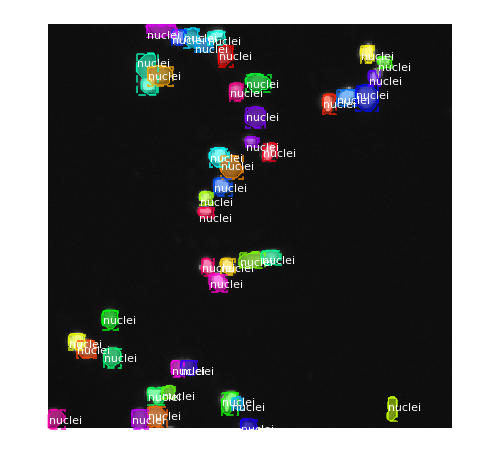

In [69]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_train.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [21]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

How it works in training dataset

Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -112.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


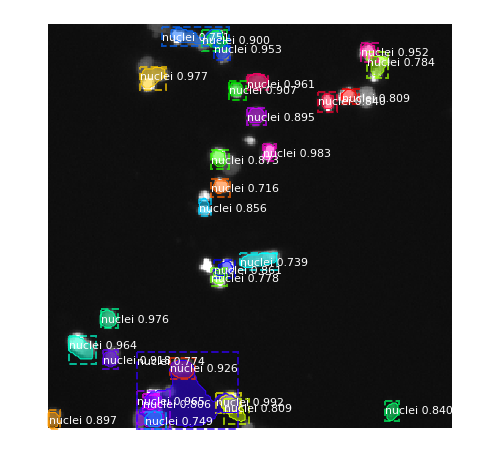

In [71]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

How it works in validation dataset

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


{'id': 122, 'source': 'nuclei', 'path': './input/stage1_train/3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20/images/3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20.png', 'maskpath': './input/stage1_train/3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20/masks/'}
original_image           shape: (256, 256, 3)         min:    0.00000  max:  213.00000
image_meta               shape: (10,)                 min:    0.00000  max:  320.00000
gt_class_id              shape: (17,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (17, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 17)        min:    0.00000  max:    1.00000


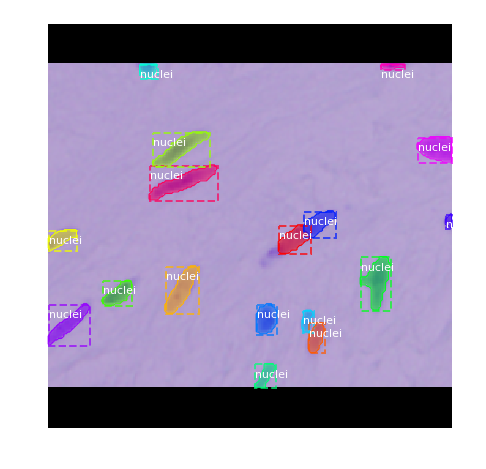

In [72]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_val.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  213.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  109.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


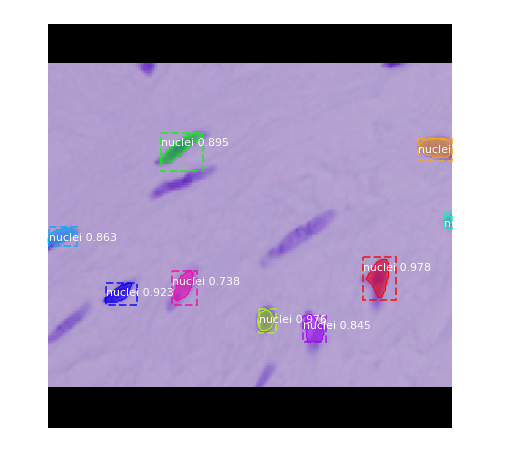

In [73]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

##Export Results for Submission


In [12]:
## Define RLE encoding functions
from skimage.morphology import label


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


def mask_encode(masks):
    n_mask = masks.shape[2]
    res = []
    for i in range(n_mask):
        encode_one = prob_to_rles(masks[:, :, i])
        res.extend(encode_one)
    return res

In [18]:
# Load test dataset
dataset_test = NucleiDataset()
dataset_test.load_nuclei(TEST_PATH, test_ids)
dataset_test.prepare()


In [19]:
# Test RLE encoding functions on train set masks
mask_test, _ = dataset_train.load_mask(0)

print(mask_test.shape)
print(pd.Series(mask_encode(mask_test)).apply(lambda x: ' '.join(str(y) for y in x)))


(256, 256, 27)
0     11966 4 12220 9 12473 14 12729 15 12984 16 132...
1     6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
2     36269 7 36523 11 36778 13 37033 15 37288 17 37...
3     19919 6 20174 8 20429 10 20685 11 20941 12 211...
4     18671 6 18926 8 19181 9 19436 10 19691 11 1994...
5               40158 3 40413 5 40669 5 40925 5 41182 3
6     58535 6 58791 10 59047 12 59303 16 59553 2 595...
7     31989 7 32244 12 32499 14 32754 15 33009 16 33...
8     31465 4 31719 7 31974 9 32230 9 32486 9 32742 ...
9     25560 5 25815 7 26070 8 26325 9 26581 9 26837 ...
10    45553 2 45787 1 45808 1 46036 9 46063 1 46290 ...
11    58148 3 58403 5 58657 10 58912 13 59167 15 594...
12              14825 3 15080 5 15336 5 15592 5 15849 3
13    19903 5 20158 7 20413 8 20666 13 20921 16 2117...
14    39235 1 39489 6 39743 10 39998 19 40254 19 405...
15    34513 4 34768 6 35024 8 35279 10 35535 11 3579...
16    42977 9 43229 16 43484 18 43740 19 43995 21 44...
17    20706 5 20961 8 21216 10 21

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


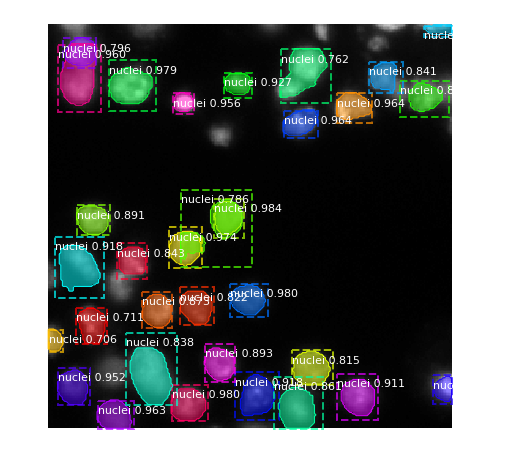

(256, 256, 32)


In [23]:
# Pick a test image to visualize
image = dataset_test.load_image(2)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

print(r['masks'].shape)

In [24]:
# Function to remove overlapping portion of masks (keep the portion with higher score)


def remove_overlap(masks):
    n_masks = masks.shape[2]

    for i in range(n_masks):
        good_mask = masks[:, :, i]
        for j in range(i + 1, n_masks):
            fix_mask = masks[:, :, j]
            overlapping = (good_mask == 1) & (fix_mask == 1)
            if np.any(overlapping):
                print('Overlapping mask detected!')
                fix_mask[overlapping] = 0
                masks[:, :, j] = fix_mask
    return masks

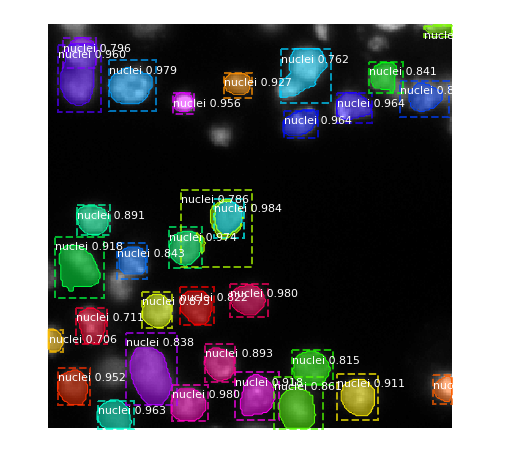

In [26]:
## Check fixed image

visualize.display_instances(image, r['rois'], remove_overlap(r['masks']), r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

In [27]:
# Run detection on all test and do RLE encoding
new_test_ids = []
rles = []
for image_id in dataset_test.image_ids:
    print('Processing: ' + test_ids[image_id])
    image = dataset_test.load_image(image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    rle = mask_encode(remove_overlap(r['masks']))
    rles = np.append(rles, rle)
    new_test_ids.extend([test_ids[image_id]] * len(rle))

print(len(rles))
print(len(new_test_ids))

Processing: 0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


Processing: 0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


Overlapping mask detected!


Processing: 0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925


Processing: 0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!

Processing: 1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c


Overlapping mask detected!
Overlapping mask detected!
Processing: 17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: 1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b


Processing: 191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829


Processing: 1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e


Overlapping mask detected!
Processing: 1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c


Overlapping mask detected!
Overlapping mask detected!
Processing: 259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4


Processing: 295682d9eb5acb5c1976a460c085734bfaf38482b0a3f02591c2bfdcd4128549


Processing: 31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a


Overlapping mask detected!
Processing: 336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523


Processing: 38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f


Processing: 3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: 432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580


Overlapping mask detected!
Processing: 43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Processing: 44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078


Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!


Processing: 4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2


Overlapping mask detected!
Overlapping mask detected!
Processing: 472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71


Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!


Processing: 4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac


Overlapping mask detected!
Processing: 505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81


Processing: 519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0


Processing: 51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b


Processing: 52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde


Overlapping mask detected!
Processing: 53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4


Processing: 550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18


Processing: 5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7


Overlapping mask detected!
Processing: 648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9


Overlapping mask detected!
Processing: 697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Processing: 78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d


Overlapping mask detected!
Processing: 7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04


Processing: 7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af


Processing: 8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: 8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: 912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: 9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2


Processing: 9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab


Overlapping mask detected!
Overlapping mask detected!


Processing: a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f


Overlapping mask detected!
Processing: a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8


Processing: ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Processing: bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d

Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb


Overlapping mask detected!
Overlapping mask detected!
Processing: ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896


Processing: d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b


Processing: da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Overlapping mask detected!
Overlapping mask detected!


Processing: dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4


Processing: df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258


Processing: eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4


Processing: f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Processing: fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!
1498
1498


In [28]:
# Save results for submission

import pandas as pd

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submit/sub-dsbowl2018-3.csv', index=False)